In [1]:
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import rasterio
import geopandas as gpd

from shapely.geometry import Polygon

import iceplant_detection_functions as ipf
import model_prep_and_evals as mpe

import warnings

## Create test/train set from samples

In [2]:
samples_fp = os.path.join(os.getcwd(),'feature_selection','samples_for_model.csv')
#samples = pd.read_csv(os.path.join(os.getcwd(),'feature_selection','samples_for_model.csv'))
#samples.head(3)

In [3]:
train, test = mpe.test_train_aois_scenes(pd.read_csv(samples_fp))

In [4]:
X_train = np.array(np.array(train.loc[:,'r':'day_in_year']))
X_train

array([[43, 51, 78, ..., 2012, 5, 126],
       [65, 59, 84, ..., 2012, 5, 126],
       [81, 86, 93, ..., 2012, 5, 126],
       ...,
       [84, 100, 71, ..., 2020, 5, 142],
       [65, 77, 72, ..., 2020, 5, 142],
       [87, 93, 84, ..., 2020, 5, 142]], dtype=object)

In [5]:
# X_test = np.array(np.array(test.loc[:,'r':'day_in_year']))
# X_test

In [6]:
y_train = np.array(train['iceplant'])
y_train

array([0, 0, 0, ..., 1, 0, 0])

In [7]:
# y_test = np.array(test['iceplant'])
# y_test

In [8]:
mpe.iceplant_proportions(y_train)

no-iceplant:iceplant ratio     2.4 :1
          counts  percentage
iceplant                    
0         247696       70.95
1         101425       29.05



In [9]:
# mpe.iceplant_proportions(y_test)

## Train model

In [10]:
from dask_ml.wrappers import ParallelPostFit

In [11]:
t0 = time.time()

rfc = ParallelPostFit(RandomForestClassifier(n_estimators = 100, random_state = 42))
rfc.fit(X_train, y_train)

print('time to train: ', (time.time()-t0))

time to train:  38.560834884643555


In [12]:
# predictions = rfc.predict(X_test)
# mpe.print_threshold_metrics(y_test, predictions)

## Feature importance

In [13]:
# # https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
# from sklearn.inspection import permutation_importance

# result = permutation_importance(
#     rfc, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
# )

In [14]:
# forest_importances = pd.Series(result.importances_mean, index=['r', 'g', 'b', 'nir', 'ndvi', 'year', 'month', 'day_in_year'])

In [15]:
# fig, ax = plt.subplots()
# forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
# ax.set_title("Feature importances using permutation on full model")
# ax.set_ylabel("Mean accuracy decrease")
# fig.tight_layout()
# plt.show()

# Pre-process NAIP scene for prediction

In [16]:
itemid = 'ca_m_3412037_nw_10_060_20200607'

t0 = time.time()
item = ipf.get_item_from_id(itemid)
#scene = ipf.get_raster_from_item(item).read([1,2,3,4])
print('time to retrieve itemid: ', (time.time()-t0))

#scene.shape

time to retrieve itemid:  0.2794044017791748


In [17]:
shape = item.properties['proj:shape']

In [18]:
#df = ipf.spectral_df(ipf.get_raster_from_item(item).read([1,2,3,4]))
df = ipf.features_over_aoi(item, 
                           ipf.get_raster_from_item(item).read([1,2,3,4]), 
                           thresh=0.05)
df.head(3)

,r,g,b,nir,ndvi,year,month,day_in_year
580,92,91,82,102,0.051546,2020,6,159
588,76,75,71,85,0.055901,2020,6,159
591,96,95,82,107,0.054187,2020,6,159


In [19]:
# df['year'] = item.datetime.year
# df['month'] = item.datetime.month
# df['day_in_year'] = day_in_year(item.datetime.day, item.datetime.month, item.datetime.year)
# df.head(3)

In [20]:
# df = df[['r','g','b','nir','ndvi','year','month','day_in_year']] # order features
# df.head(3)

In [21]:
# thresh = 0.05
# veg = df[df.ndvi>thresh]

In [22]:
# pixels = np.array(df)
# print(pixels.shape)
# pixels

This array is WAY TOO BIG. Mostly because the NDVI feature is a float and is making the whole array into a float. Maybe rescale the NDVI to make it uint16? Not sure if this would affect the model's predictions.

In [23]:
# Make dask data array of pixel values from NAIP scene raster
import dask.array as da

In [24]:
da_pixels = da.from_array(np.array(df), chunks=728802)
da_pixels

dask.array<array, shape=(23114446, 8), dtype=float64, chunksize=(728802, 8), chunktype=numpy.ndarray>

# Predict using dask

In [25]:
import dask
import dask_gateway

cluster = dask_gateway.GatewayCluster()
client = cluster.get_client()
#cluster.adapt(minimum=4, maximum=50)
cluster.scale(30)
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://pccompute.westeurope.cloudapp.azure.com/compute/services/dask-gateway/clusters/prod.b1378ddf9fcd45da843bf5579420d1ce/status,


In [26]:
scene_preds = rfc.predict(da_pixels)
scene_preds

dask.array<_predict, shape=(23114446,), dtype=int64, chunksize=(728802,), chunktype=numpy.ndarray>

In [27]:
t0 = time.time()
#print('starting time: ', t0)

preds = scene_preds.compute()
print((time.time()-t0))

72.8295247554779


In [28]:
predictions_df = pd.DataFrame({'prediction': preds}, index = df.index)
predictions_df

,prediction
580,0
588,0
591,0
592,0
593,0
...,...
119283715,0
119473061,0
119473062,0
119483582,0


In [29]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    nrows = shape[0]
    ncols = shape[1]
    index = predictions_df[predictions_df.prediction == 1].index.to_numpy()
    preds = ipf.indices_backto_image(nrows,ncols, index)
    print('converted back to image')

converted back to image


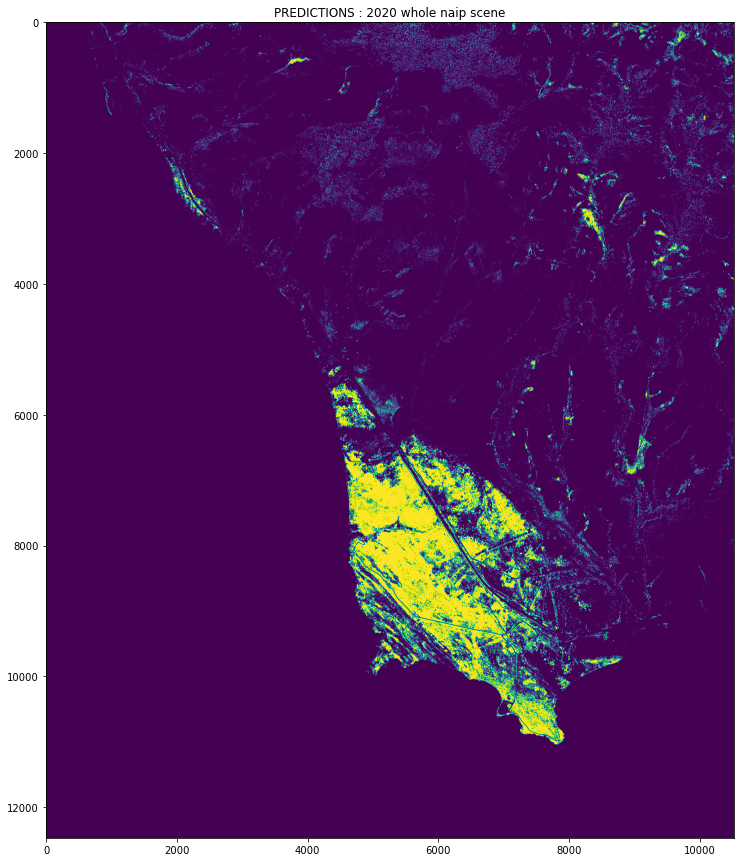

In [30]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title("PREDICTIONS : 2020 whole naip scene")
ax.imshow(preds)
plt.show()

In [31]:
# aois = gpd.read_file(os.path.join(os.getcwd(),'areas_of_interest','areas_of_interest.shp'))
# aois

,name,region,itemid_12,itemid_14,itemid_16,itemid_18,itemid_20,geometry
0,conception point,dangermond,ca_m_3412037_nw_10_1_20120518_20120730,ca_m_3412037_nw_10_1_20140603_20141030,NA,ca_m_3412037_nw_10_060_20180913_20190208,ca_m_3412037_nw_10_060_20200607,"POLYGON ((-120.47317 34.44646, -120.47317 34.4..."
1,government point,dangermond,ca_m_3412037_nw_10_1_20120518_20120730,ca_m_3412037_nw_10_1_20140603_20141030,NA,ca_m_3412037_nw_10_060_20180913_20190208,ca_m_3412037_nw_10_060_20200607,"POLYGON ((-120.46002 34.44189, -120.46002 34.4..."
2,near dangermond test plots,dangermond,ca_m_3412037_nw_10_1_20120518_20120730,ca_m_3412037_nw_10_1_20140603_20141030,NA,ca_m_3412037_nw_10_060_20180913_20190208,ca_m_3412037_nw_10_060_20200607,"POLYGON ((-120.47391 34.45923, -120.47391 34.4..."
3,dangermond inland,dangermond,ca_m_3412037_nw_10_1_20120518_20120730,ca_m_3412037_nw_10_1_20140603_20141030,NA,ca_m_3412037_nw_10_060_20180913_20190208,ca_m_3412037_nw_10_060_20200607,"POLYGON ((-120.45624 34.45427, -120.45624 34.4..."
4,campus point,goleta,ca_m_3411934_sw_11_1_20120505_20120730,ca_m_3411934_sw_11_1_20140601_20141030,ca_m_3411934_sw_11_.6_20160713_20161004,ca_m_3411934_sw_11_060_20180722_20190209,ca_m_3411934_sw_11_060_20200521,"POLYGON ((-119.85347 34.40287, -119.85347 34.4..."
5,campus lagoon zoom,goleta,ca_m_3411934_sw_11_1_20120505_20120730,ca_m_3411934_sw_11_1_20140601_20141030,ca_m_3411934_sw_11_.6_20160713_20161004,ca_m_3411934_sw_11_060_20180722_20190209,ca_m_3411934_sw_11_060_20200521,"POLYGON ((-119.85019 34.40848, -119.85019 34.4..."
6,campus lagoon tree,goleta,ca_m_3411934_sw_11_1_20120505_20120730,ca_m_3411934_sw_11_1_20140601_20141030,ca_m_3411934_sw_11_.6_20160713_20161004,ca_m_3411934_sw_11_060_20180722_20190209,ca_m_3411934_sw_11_060_20200521,"POLYGON ((-119.84943 34.40982, -119.84943 34.4..."
7,shoreline park,santa barbara,NA,NA,NA,ca_m_3411935_sw_11_060_20180724_20190209,NA,"POLYGON ((-119.71415 34.39310, -119.71415 34.3..."
